# Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

The goal of this project is to build a person of interest (POI, which means an individual who was indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity) identifier based on financial and email data made public as a result of the Enron scandal. Machine learning is an excellent tool for this kind of classification task as it can use patterns discovered from labeled data to infer the classes of new observations.

This dataset combines the public record of Enron emails and financial data with a hand-generated list of POI’s in the fraud case.

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("train_data.csv")
y_train = df["poi"]
x_train = df.drop(["poi"], axis=1)

In [3]:
print("# of features: {}".format(x_train.shape[1]))
print("# of samples: {}".format(x_train.shape[0]))
x_train.head()

# of features: 21
# of samples: 113


,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,NaN,1617011.0,174839.0,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,NaN,1920000.0,22122.0,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,NaN,1573324.0,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,NaN,602671.0,907502.0,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,NaN,375304.0,486.0,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0


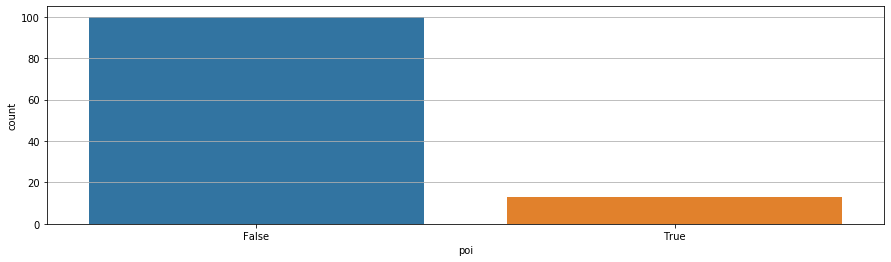

In [4]:
plt.figure(figsize=(15, 4))
sns.countplot(y_train)
plt.grid(axis="y")
plt.show()

In [5]:
# Getting slight information about the dataframe
print("There are total of {} people in the dataset".format(len(df.index)))
print("Out of which {} are POI".format(df['poi'].value_counts()[True]))

There are total of 113 people in the dataset
Out of which 13 are POI


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bonus,61.0,1.147436e+06,1.505189e+06,70000.0,450000.00,750000.0,1000000.00,8000000.0
deferral_payments,28.0,6.344374e+05,8.603646e+05,-102500.0,76567.50,195190.0,834205.25,2964506.0
deferred_income,34.0,-4.625664e+05,8.095392e+05,-3504386.0,-552703.25,-117534.0,-27083.25,-1042.0
director_fees,13.0,8.939785e+04,4.114339e+04,3285.0,101250.00,108579.0,112492.00,125034.0
exercised_stock_options,81.0,2.985081e+06,6.004174e+06,3285.0,400478.00,850010.0,2165172.00,34348384.0
expenses,73.0,5.104055e+04,4.759668e+04,148.0,18834.00,41953.0,59175.00,228763.0
from_messages,65.0,7.113231e+02,2.074498e+03,12.0,19.00,45.0,215.00,14368.0
from_poi_to_this_person,65.0,6.480000e+01,9.186321e+01,0.0,10.00,28.0,88.00,528.0
from_this_person_to_poi,65.0,4.009231e+01,8.890141e+01,0.0,0.00,7.0,27.00,411.0
loan_advances,2.0,4.096250e+07,5.736404e+07,400000.0,20681250.00,40962500.0,61243750.00,81525000.0


# Missing Values

There are lots of missing values in this dataset.

In [7]:
for column in df.columns:
    df[column] = df[column].apply(lambda x: np.NaN if x == 'NaN' else x)

In [8]:
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.style.background_gradient(cmap='Blues'))
na_check(df)

,Missing Ratio
loan_advances,98.230088
restricted_stock_deferred,91.150442
director_fees,88.495575
deferral_payments,75.221239
deferred_income,69.911504
long_term_incentive,56.637168
bonus,46.017699
from_messages,42.477876
from_poi_to_this_person,42.477876
from_this_person_to_poi,42.477876


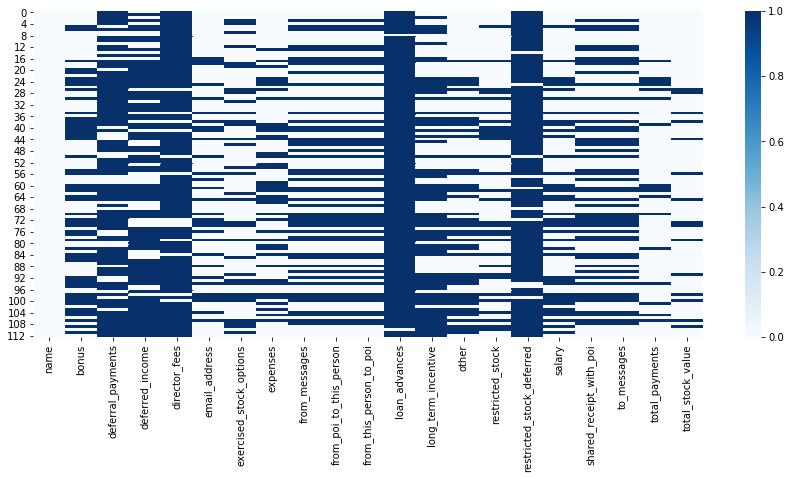

In [9]:
plt.figure(figsize=(15, 6))
sns.heatmap(x_train.isnull(), cbar=True, cmap="Blues")
plt.show()

# Features Description

## Financail Features
* `salary`: Reflects items such as base salary, executive cash allowances, and benefits payments.
* `deferral_payments`: Reflects distributions from a deferred compensation arrangement due to termination of employment or due to in-service withdrawals as per plan provisions.
* `total_payments`: 
* `loan_advances`: Reflects total amount of loan advances, excluding repayments, provided by the Debtor in return for a promise of repayment. In certain instances, the terms of the promissory notes allow for the option to repay with stock of the company.
* `bonus`: Reflects annual cash incentives paid based upon company performance. Also may include other retention payments.
* `restricted_stock_deferred`: Reflects value of restricted stock voluntarily deferred prior to release under a deferred compensation arrangement.
* `deferred_income`: Reflects voluntary executive deferrals of salary, annual cash incentives, and long-term cash incentives as well as cash fees deferred by non-employee directors under a deferred compensation arrangement. May also reflect deferrals under a stock option or phantom stock unit in lieu of cash arrangement.
* `total_stock_value`: 
* `expenses`: Reflects reimbursements of business expenses. May include fees paid for consulting services.
* `exercised_stock_options`: Reflects amounts from exercised stock options which equal the market value in excess of the exercise price on the date the options were exercised either through cashless (same-day sale), stock swap or cash exercises. The reflected gain may differ from that realized by the insider due to fluctuations in the market price and the timing of any subsequent sale of the securities.
* `other`: Reflects items such as payments for severance, consulting services, relocation costs, tax advances and allowances for employees on international assignment (i.e. housing allowances, cost of living allowances, payments under Enron’s Tax Equalization Program, etc.). May also include payments provided with respect to employment agreements, as well as imputed income amounts for such things as use of corporate aircraft.
* `long_term_incentive`: Reflects long-term incentive cash payments from various long-term incentive programs designed to tie executive compensation to long-term success as measured against key performance drivers and business objectives over a multi-year period, generally 3 to 5 years.
* `restricted_stock`: Reflects the gross fair market value of shares and accrued dividends (and/or phantom units and dividend equivalents) on the date of release due to lapse of vesting periods, regardless of whether deferred.
* `director_fees`: Reflects cash payments and/or value of stock grants made in lieu of cash payments to non-employee directors.

## Email Features
* `to_messages`
* `email_address`
* `from_poi_to_this_person`
* `from_messages`
* `from_this_person_to_poi`
* `shared_receipt_with_poi`

Numbers of remain columns: 14


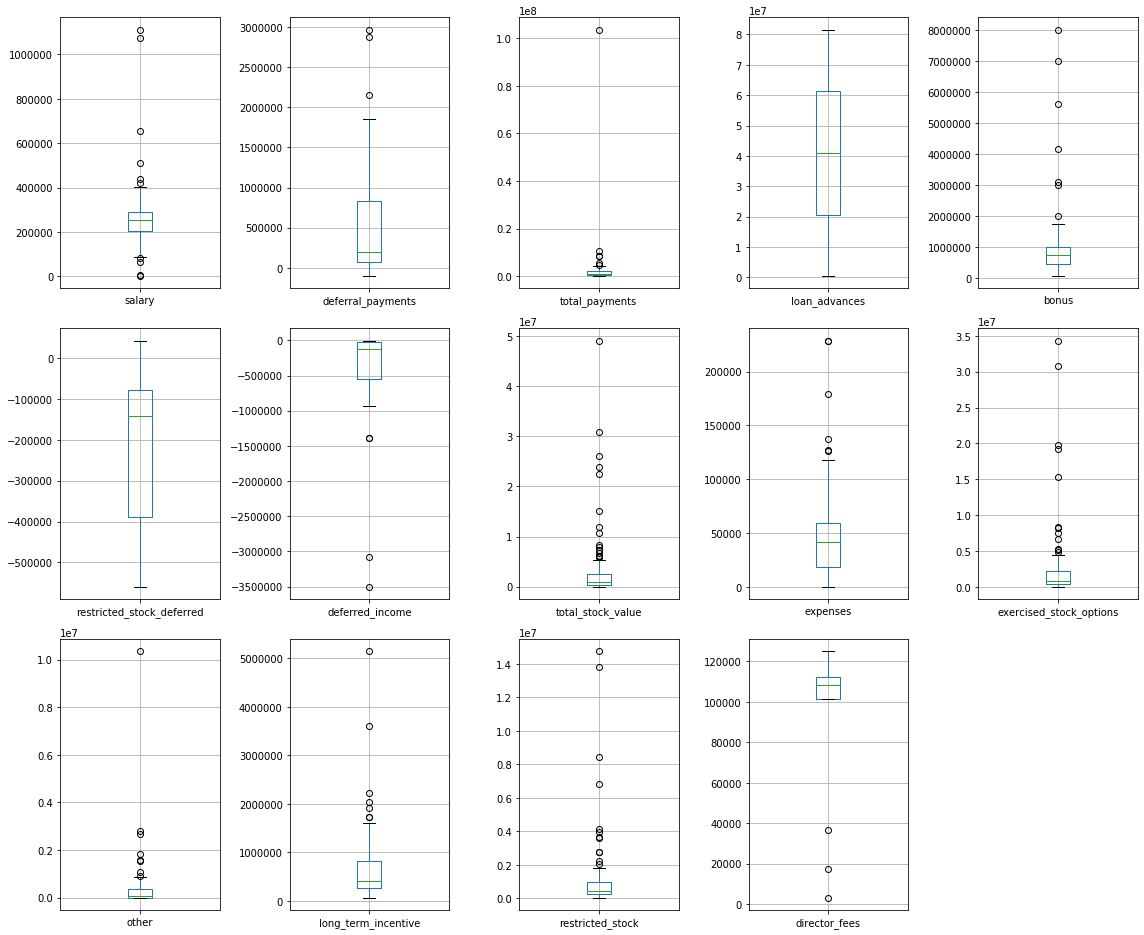

In [10]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 
                      'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 
                      'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 
                      'restricted_stock', 'director_fees']
email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 
                  'from_this_person_to_poi', 'shared_receipt_with_poi']

numeric_columns = list(x_train[financial_features].
                       columns[list(x_train[financial_features].dtypes.isin([np.dtype('int'), np.dtype('float')]))])
numeric_columns = list(x_train[numeric_columns].
                       columns[list(x_train[numeric_columns].
                                    apply(lambda x:len(x.unique()) != 2))])
print("Numbers of remain columns: %i" % len(numeric_columns))

plt.figure(figsize=(16, 56))
for i, col in enumerate(numeric_columns):
    plt.subplot(13, 5, i+1)
    x_train.boxplot(col)
plt.tight_layout()
plt.show()

# Outliers
From figures above, it can see that some of the features may have outliers.
* salary
* deferral_payments
* total_payments
* bonus
* deferred_income
* total_stock_value
* expenses
* exercised_stock_options
* other
* long_term_incentive
* restricted_stock
* director_fees

# Emprical Cumulative Density Plot
* [ECDF](https://zh.wikipedia.org/wiki/%E7%BB%8F%E9%AA%8C%E5%88%86%E5%B8%83%E5%87%BD%E6%95%B0)
* [ECDF with Python](https://stackoverflow.com/questions/14006520/ecdf-in-python-without-step-function)

**Why is the Empirical Cumulative Distribution Useful in Exploratory Data Analysis?**

The empirical CDF is useful because

1. It approximates the true CDF well if the sample size (the number of data) is large, and knowing the distribution is helpful for statistical inference.
2. A plot of the empirical CDF can be visually compared to known CDFs of frequently used distributions to check if the data came from one of those common distributions.
3. It can visually display “how fast” the CDF increases to 1; plotting key quantiles like the quartiles can be useful to “get a feel” for the data.

$$P(|ECDF(x)-CDF(x)|<\epsilon)\geq1-\frac{1}{4n\epsilon^2}$$

$$1-\frac{1}{4n\times0.05^2}\geq0.9$$

$$n\geq\frac{1}{4\times0.1\times0.05^2}=1000$$

Therefore, if we want the probability of the error ($\epsilon=0.05$) to be at least 0.9, by Chebyshev's Inequality, we need at least 1000 samples.

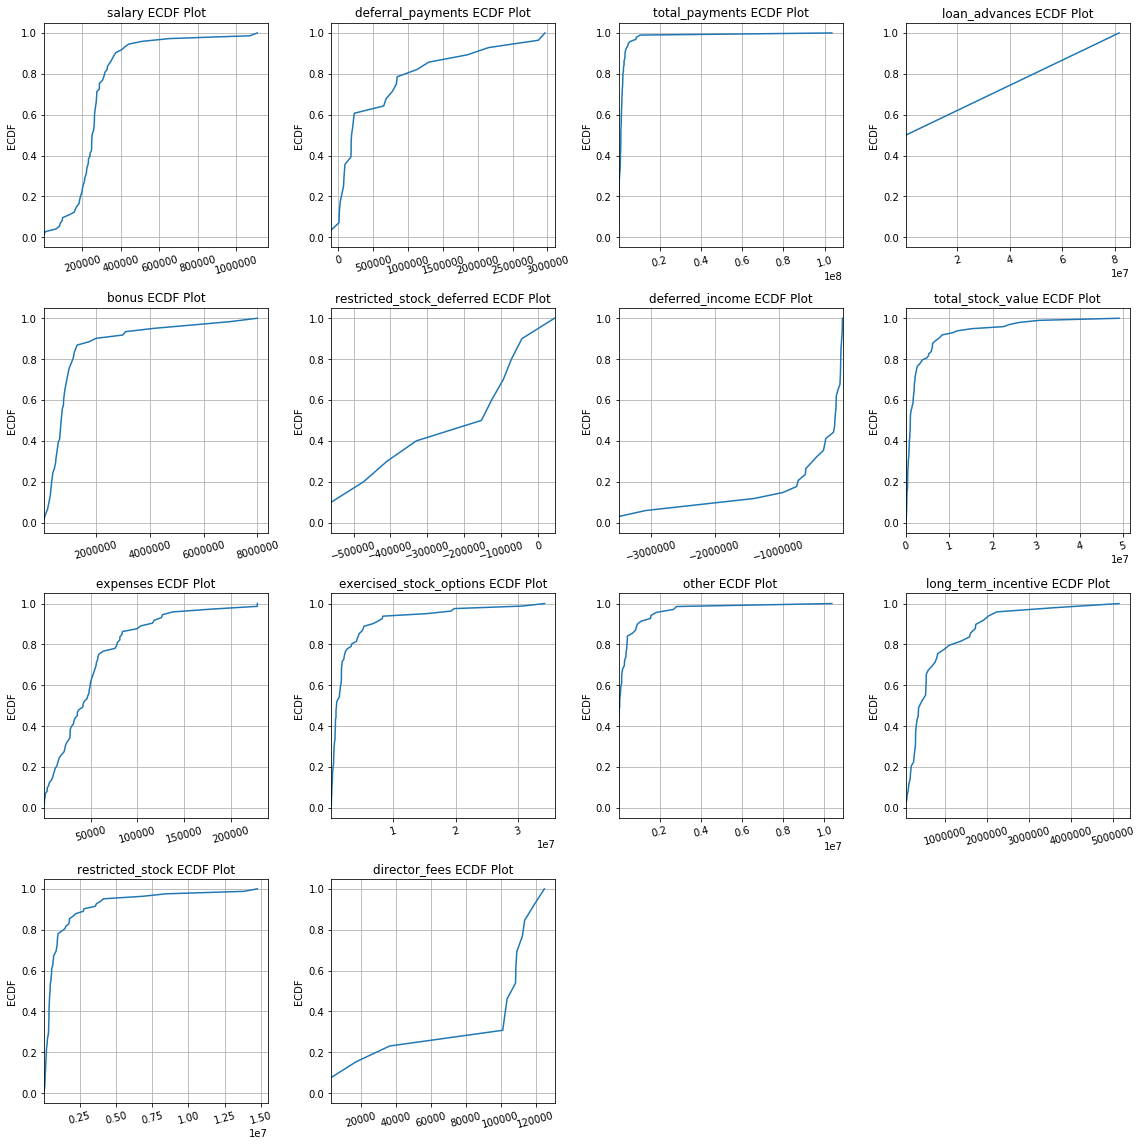

In [11]:
plt.figure(figsize=(16, 16))
for i, feature in enumerate(financial_features):
    cdf = x_train[feature].value_counts().sort_index().cumsum()

    plt.subplot(4, 4, i+1)
    plt.plot(list(cdf.index), cdf/cdf.max())
    plt.xlabel('Value')
    plt.ylabel('ECDF')
    plt.xlim([cdf.index.min(), cdf.index.max()*1.05])
    plt.ylim([-0.05, 1.05])
    plt.title(feature + " ECDF Plot")
    plt.xticks(rotation=15)
    plt.xlabel(None)
    plt.grid()
plt.tight_layout()
plt.show()

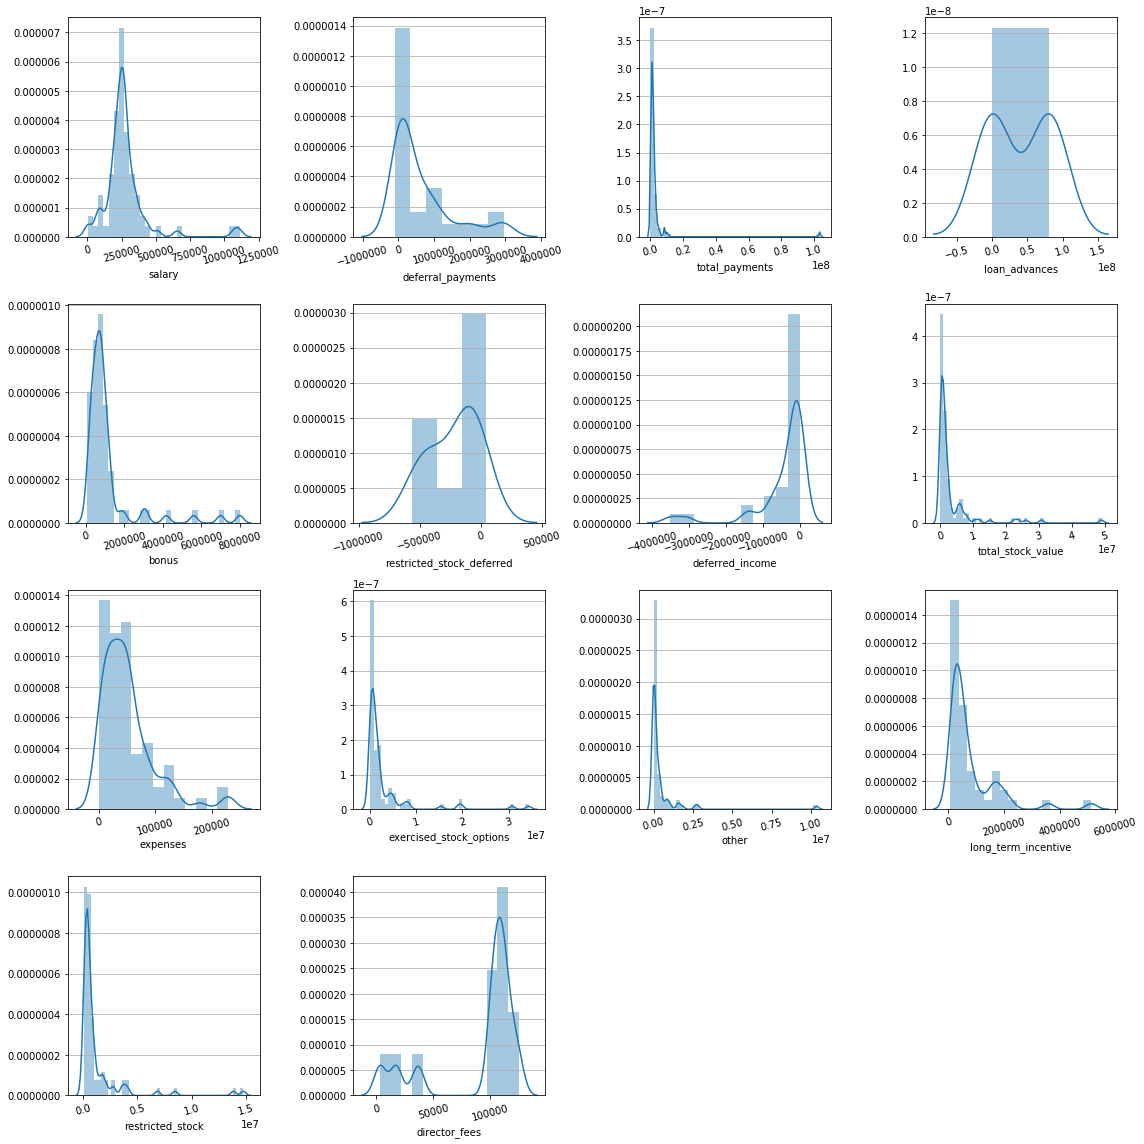

In [12]:
plt.figure(figsize=(16, 16))
for i, feature in enumerate(financial_features):
    plt.subplot(4, 4, i+1)
    sns.distplot(x_train[feature])
    plt.xticks(rotation=15)
    plt.xlabel(feature)
    plt.grid(axis="y")
plt.tight_layout()
plt.show()

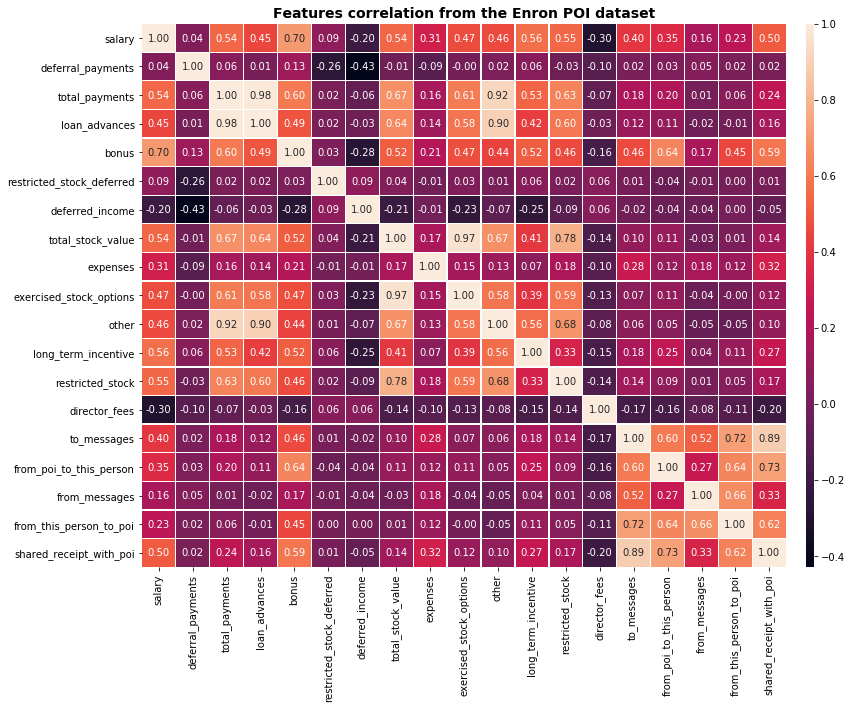

In [13]:
## Calculating the correlation among features by Pearson method
df_copy = df.copy()
df_copy = df_copy.fillna(0)
correlation_dataframe = df_copy[financial_features + email_features].corr()

# Drawing a heatmap with the numeric values in each cell
plt.figure(figsize=(14, 10))
plt.title('Features correlation from the Enron POI dataset', fontsize=14, fontweight='bold', loc='center')

cbar_kws = {'orientation': "vertical", 'pad': 0.025, 'aspect': 70}
sns.heatmap(correlation_dataframe, annot=True, fmt='.2f', linewidths=.3, cbar_kws=cbar_kws)
plt.show()